## COVID-19 OxCGRT Plots

Dataset: https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker#data

## Configuration
Loading in dependencies and any other requirements

In [65]:
# Load dependencies
import requests, io, json, urllib
from datetime import datetime, date, timedelta
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import cycle
from textwrap import wrap
import pickle
import numpy as np
import seaborn as sns
import covsirphy as cs
from scipy import stats
import datetime as dt
import scipy.stats
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

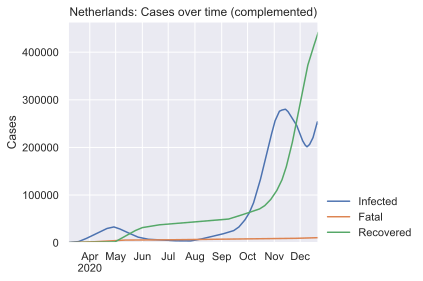

In [105]:
# Select country of interest (using ISO 3166-1 alpha-3 country code)
country_iso3 = "NLD"
country = "Netherlands"

# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()
snl = cs.Scenario(jhu_data, population_data, country=country)
data_df = snl.records();

### Calculate slope of infections for every day

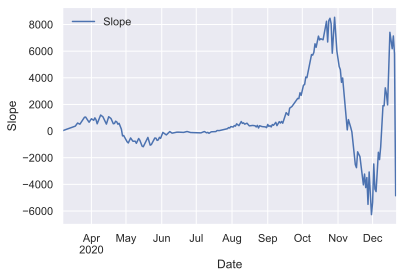

In [106]:
data_df['date_ordinal'] = pd.to_datetime(data_df['Date']).map(dt.datetime.toordinal)
slopes = []
for i in range(len(data_df) - 1):
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df['date_ordinal'][i:i+2], data_df['Infected'][i:i+2])
    slopes.append(slope)
slopes.append(None)

data_df["Slope"] = slopes
data_df.plot(x="Date", y="Slope", ylabel="Slope");


## Access data API

In [124]:
# Get date range 
date_start = "2020-02-01" # date to start tracking (will go until today)
date_list = pd.date_range(start=date_start, end=datetime.today()).tolist()
date_strs = [date.strftime("%Y-%m-%d") for date in date_list]
n = len(date_strs)

# Arrange urls
urls = [f"https://covidtrackerapi.bsg.ox.ac.uk/api/v2/stringency/actions/{country_iso3}/{date_str}" for date_str in date_strs]



# Submit requests
dfs = [None for _ in range(0,n)]
for i in range(0,n):
    r = urllib.request.urlopen(urls[i])
    data = json.loads(r.read().decode("utf-8"))
    dfs[i] = pd.DataFrame(data['policyActions'])
    dfs[i]["Date"] = date_strs[i]
    
# Collapse into one dataframe
df = pd.concat(dfs, axis=0)

# Add field to store policy code category (e.g. C, E, H)
df["policy_category"] = df["policy_type_code"].str[0]

# Convert to datetime and numeric
df["Date"] = pd.to_datetime(df["Date"])
df["policyvalue"] = pd.to_numeric(df["policyvalue"].str.replace(",",""))

# Preview result
df.head(5)

,policy_type_code,policy_type_display,policyvalue,policyvalue_actual,flagged,is_general,notes,flag_value_display_field,policy_value_display_field,Date,policy_category
0,C1,School closing,0.0,0.0,None,None,None,General,No measures,2020-02-01,C
1,C2,Workplace closing,0.0,0.0,None,None,None,General,No measures,2020-02-01,C
2,C3,Cancel public events,0.0,0.0,None,None,None,General,No Measures,2020-02-01,C
3,C4,Restrictions on gatherings,0.0,0.0,None,None,None,General,No restrictions,2020-02-01,C
4,C5,Close public transport,0.0,0.0,None,None,None,General,No Measures,2020-02-01,C


# Timeseries - by category

{'C1': -0.27585172896064636, 'C2': 0.1947146794704167, 'C3': 0.36026880970089276, 'C4': 0.5444642279936558, 'C5': -0.21778883855400066, 'C6': -0.18761494602033976, 'C7': 0.2253528758526271, 'C8': 0.13975097000667758}


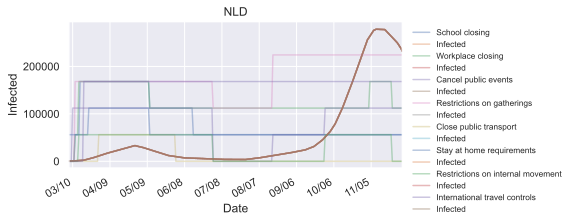

In [108]:
# Select category to plot
desired_category = "C"

column = "Infected"

# Reduce subset to desired category
df_subset = df[df["policy_category"] == desired_category]
df_subset = pd.merge(df_subset, data_df, on="Date")

ylim = int(np.max(data_df[column]) / 5)

# Get unique policy types per category
policy_codes = df_subset["policy_type_code"].unique()
policy_types = df_subset["policy_type_display"].unique()
policy_dict = {policy_code : policy_type for policy_code, policy_type in zip(policy_codes,policy_types)}

# policy_codes = ["C2","C4"]
corrs_netherlands = {}
# Create time-series plot for catgory
fig, ax = plt.subplots(figsize=(6,3))
for policy_code in policy_codes:
    df_subsubset = df_subset[df_subset["policy_type_code"] == policy_code]
    df_subsubset["scaled_policy_val"] = df_subsubset["policyvalue_actual"] * ylim
    df_subsubset.plot(x="Date",y="scaled_policy_val",ax=ax,label=policy_dict[policy_code],alpha=0.4)
    df_subsubset.plot(x="Date",y=column,ax=ax,label=column,alpha=0.4)
    rho = scipy.stats.pointbiserialr(df_subsubset["scaled_policy_val"], df_subsubset[column])
    corrs_netherlands[policy_code] = rho.correlation
print(corrs_netherlands)
plt.legend(fontsize="small", bbox_to_anchor=(1.01, 1.0))
plt.ylabel(column)
date_form = mdates.DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
plt.title(country_iso3)
fig.autofmt_xdate()
plt.show()

In [104]:
total_corrs = {
    "Italy": corrs_italy,
    "Netherlands": corrs_netherlands,
    "Spain": corrs_spain,
}
total_corrs

{'Italy': {'C1': -0.3747452689712111,
  'C2': 0.4380856132052202,
  'C3': nan,
  'C4': 0.4490979423419637,
  'C5': 0.44041049933869775,
  'C6': 0.3976201451980901,
  'C7': 0.49113024126037286,
  'C8': 0.14804284732130008},
 'Netherlands': {'C1': -0.27585172896064636,
  'C2': 0.1947146794704167,
  'C3': 0.36026880970089276,
  'C4': 0.5444642279936558,
  'C5': -0.21778883855400066,
  'C6': -0.18761494602033976,
  'C7': 0.2253528758526271,
  'C8': 0.13975097000667758},
 'Spain': {'C1': -0.5370121955621281,
  'C2': 0.13603667741637843,
  'C3': 0.14248265946239005,
  'C4': 0.4257130417570406,
  'C5': -0.3916940297488952,
  'C6': 0.2592926459209263,
  'C7': 0.5780227223389177,
  'C8': -0.23724476265176908}}

# Timeseries - selected policy types

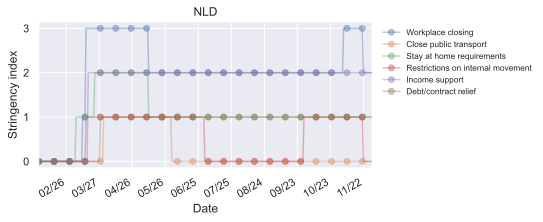

In [125]:
# Select category to plot
desired_codes = ["C2","C5","C6","C7","E1","E2"]

# Reduce subset to desired category
df_subset = df[df["policy_type_code"].isin(desired_codes)]

# Get unique policy types per category
policy_codes = df_subset["policy_type_code"].unique()
policy_types = df_subset["policy_type_display"].unique()
policy_dict = dict.fromkeys(policy_codes)
for policy_code, policy_type in zip(policy_codes,policy_types):
    # Get values
    df_policy = df_subset[df_subset["policy_type_code"]==policy_code]
    values = df_policy["policyvalue_actual"].unique()
    names = df_policy["policy_value_display_field"].unique()
    value_dict = {value : name for value, name in zip(values,names)}
    # Arrange dictionary
    policy_dict[policy_code] = {
        "type" : policy_type,
        "values" : value_dict
    }
    
# Create time-series plot for catgory
fig, ax = plt.subplots(figsize=(6,3))
for policy_code in policy_codes:
    df_subsubset = df_subset[df_subset["policy_type_code"] == policy_code]
    df_subsubset.plot(x="Date",y="policyvalue_actual",ax=ax,label=policy_dict[policy_code]["type"],marker='o',markevery=14,alpha=0.4)
plt.legend(fontsize="small", bbox_to_anchor=(1.01, 1.0))
plt.ylabel("Stringency index")
date_form = mdates.DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
plt.title(country_iso3)
fig.autofmt_xdate()
plt.show()

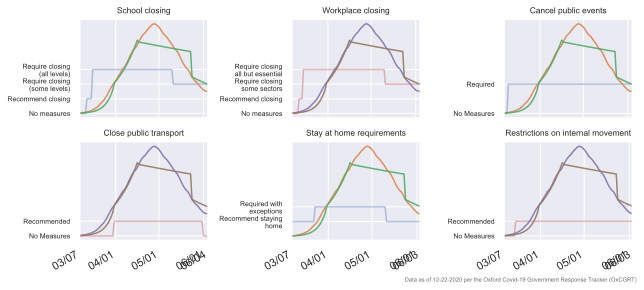

In [154]:
# Select category to plot
desired_codes = ["C2","C5","C6","C7","C1", "C3"]

# Reduce subset to desired category
df_subset = df[df["policy_type_code"].isin(desired_codes)]

SIR_plot = open("data/plot_sim", 'rb')
SIR = pickle.load(SIR_plot) 
SIR_plot.close()

# Merge with SIR predictions
df_subset = pd.merge(df_subset, data_df, on="Date")
df_subset = df_subset.rename(columns={'Infected': 'Infected_real', 'Confirmed': 'Confirmed_real', 'Recovered': 'Recovered_real'})
df_subset = pd.merge(df_subset, SIR, on="Date")

# Select days of dataset 
# df_subset = df_subset[:150]
df_subset = df_subset[:int(len(df_subset)/3)]
column = "Infected"
ylim = int(np.max(df_subset[column]) / 5)

# Get unique policy types per category
policy_codes = df_subset["policy_type_code"].unique()
policy_types = df_subset["policy_type_display"].unique()
policy_dict = dict.fromkeys(policy_codes)
for policy_code, policy_type in zip(policy_codes,policy_types):
    # Get values
    df_policy = df_subset[df_subset["policy_type_code"]==policy_code]
    values = df_policy["policyvalue_actual"].unique()
    names = df_policy["policy_value_display_field"].unique()
    value_dict = {value : name for value, name in zip(values,names)}
    # Arrange dictionary
    policy_dict[policy_code] = {
        "type" : policy_type,
        "values" : value_dict
    }
    
# Create time-series plot for catgory
nrow, ncol = 2, 3
colors = map('C{}'.format, cycle(range(nrow*ncol)))
fig, axs = plt.subplots(nrow,ncol,figsize=(ncol*3,nrow*2))
for policy_code,ax in zip(policy_codes,axs.flatten()):
    # Plot data
    df_subsubset = df_subset[df_subset["policy_type_code"] == policy_code]
    # Rescale to fit plot
    df_subsubset["policyvalue_actual"] = df_subsubset["policyvalue_actual"].values * ylim
    df_subsubset.plot(x="Date",y="policyvalue_actual",ax=ax,alpha=0.4,color=next(colors))
    df_subsubset.plot(x="Date",y=column + "_real",ax=ax,alpha=0.9,color=next(colors))
    df_subsubset.plot(x="Date",y=column,ax=ax, alpha=0.9,color=next(colors))
    # Format dates
    date_form = mdates.DateFormatter("%m/%d")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
    ax.set(xlabel=None)
    # Add y axis labels 
    y_vals = policy_dict[policy_code]["values"].keys()
    scaled_y_vals = []
    for i in y_vals:
        scaled_y_vals.append(i * ylim)
    ax.yaxis.set_ticks(scaled_y_vals)
    labels = list(policy_dict[policy_code]["values"].values())
    labels_wrap = [ '\n'.join(wrap(l, 18)) for l in labels ]
    ax.yaxis.set_ticklabels(labels_wrap, fontsize="x-small")
    ax.get_legend().remove()
    ax.set_title(policy_dict[policy_code]["type"],fontsize="small")

fig.autofmt_xdate()
plt.figtext(0.99, 0.005, f"Data as of {datetime.today().strftime('%m-%d-%Y')} per the Oxford Covid-19 Government Response Tracker (OxCGRT)", ha='right', fontsize="xx-small",color="dimgray") 
plt.tight_layout()
# plt.savefig(f"{country_iso3}_OxCGRT.png",dpi=300)
plt.show()

In [ ]:
policy_codes

In [220]:
SIR_plot = open("data/plot_sim", 'rb')
SIR = pickle.load(SIR_plot) 
SIR_plot.close()
SIR = SIR.rename(columns={"Infected": "Infected_SIR"})

SIRD_plot = open("data/plot_sim_SIRD", 'rb')
SIRD = pickle.load(SIRD_plot) 
SIRD_plot.close()
SIRD = SIRD.rename(columns={"Infected": "Infected_SIRD"})

SIRF_plot = open("data/plot_sim_SIRF", 'rb')
SIRF = pickle.load(SIRF_plot) 
SIRF_plot.close()
SIRF = SIRF.rename(columns={"Infected": "Infected_SIRF"})

SIRFV_plot = open("data/plot_sim_SIRFV", 'rb')
SIRFV = pickle.load(SIRFV_plot) 
SIRFV_plot.close()
SIRFV = SIRFV.rename(columns={"Infected": "Infected_SIRFV"})

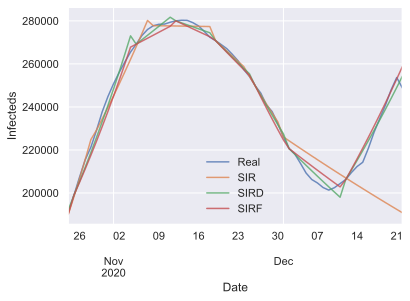

In [231]:
total = pd.merge(SIR[["Infected_SIR", "Date"]], data_df, on="Date")
total = pd.merge(SIRD[["Infected_SIRD", "Date"]], total, on="Date")
total = pd.merge(SIRF[["Infected_SIRF", "Date"]], total, on="Date")

total[-60:].plot(x="Date", y=["Infected", "Infected_SIR", "Infected_SIRD", "Infected_SIRF"], 
                         label=["Real", "SIR", "SIRD", "SIRF"], 
                 alpha=0.8,
                 ylabel="Infecteds");


In [230]:
days_offset = 25
variants = [SIR, SIRD, SIRF, SIRFV]
names = ["SIR", "SIRD", "SIRF", "SIRFV"]
for variant, name in zip(variants, names):
    print(name)
    MAPE = np.mean(np.abs(np.array(total["Infected_" + name]) -
                              np.array(total["Infected"])) / 
                               np.array(total["Infected_" + name]))
    MAPE = MAPE / len(total["Infected_" + name])
    print("MAPE: " + str(MAPE*100) + " %") 
    
    sum_errs = np.sum((np.array(total["Infected_" + name]) - np.array(total["Infected"]))**2)
    stdev = np.sqrt(1/(len(total["Infected_" + name])) * sum_errs)
    print("Standard deviation:", stdev)
    print("")


SIR
MAPE: 0.06297101282092972 %
Standard deviation: 7726.744818354784

SIRD
MAPE: 0.06272250197961621 %
Standard deviation: 2750.609962969101

SIRF
MAPE: 0.0636914671434873 %
Standard deviation: 2930.691707287123

SIRFV
MAPE: 1.5477074715579828 %
Standard deviation: 14611.571193484568



In [233]:
df["policy_type_display"].unique()

array(['School closing', 'Workplace closing', 'Cancel public events',
       'Restrictions on gatherings', 'Close public transport',
       'Stay at home requirements', 'Restrictions on internal movement',
       'International travel controls', 'Income support',
       'Debt/contract relief', 'Fiscal measures', 'International support',
       'Public information campaigns', 'Testing policy',
       'Contact tracing', 'Emergency investment in healthcare',
       'Investment in vaccines', 'Facial Coverings', 'Vaccination policy',
       'Wildcard', 'No data.  Data may be inferred for last 7 days.'],
      dtype=object)